<a href="https://colab.research.google.com/github/subhajitphy/NUS_Projects/blob/main/cgws_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
from astropy.constants import GM_sun, c, pc
#from torchdiffeq import odeint

# Constants
GM_sun, c, pc = GM_sun.value, c.value, pc.value
dsun, tsun = GM_sun/(c**2), GM_sun/(c**3)
yr = 365.25 * 24 * 3600
tsun, yr = torch.tensor(tsun), torch.tensor(yr)

In [ ]:
def f_rhs(omg,m_chirp,eta,chi_A,chi_S):
  m_total=m_chirp/eta**(3/5)
  nu=1
  delta=torch.sqrt(1-4*eta)
  tN_omg = tsun * m_chirp * omg  #post-Newtonian relation
  tm_omg = tsun * m_total * omg  #post-Newtonian relation
  Q_15=(-113/12*chi_A*delta+19/3*chi_S*eta-113/12*chi_S+4*torch.pi)
  return ((96/5) * omg**2 * tN_omg**(5/3) * (1 + (-743/336 - (11/4)*eta) * tm_omg**(2/3) * nu
          + Q_15 * tm_omg * nu**(3/2) + (34103/18144 + (13661/2016)*eta
          + (59/18)*eta**2) * tm_omg**(4/3) * nu**2))

In [ ]:
num_points = 10000
t_span = torch.linspace(0, 10*yr, num_points, dtype=torch.float64)

omg_a, m_c, eta, nu, chi_A, chi_S = map(
    lambda x: torch.tensor(x, dtype=torch.float64),
    [5e-7, 1e9, 1/4, 1.0, 0.4, 0.5]
)


In [ ]:
f_rhs(omg_a,m_c,eta,chi_A,chi_S)

tensor(2.0711e-16, dtype=torch.float64)

In [ ]:
def get_omg(t,t_a,omg_a,m_c,eta,nu,chi_A,chi_S):
    m=m_c/eta**(3/5)
    tN_ = m_c*omg_a*tsun
    tm_ = m*omg_a*tsun
    tmta_ = t-t_a
    delta=torch.sqrt(1-4*eta)
    tau = 1-256/5*omg_a*tN_**(5/3)*tmta_
    Q15=(-113/12*chi_A*delta+19/3*chi_S*eta-113/12*chi_S+4*torch.pi)
    ww=(omg_a*(((371/128*eta**2+56975/16128*eta+1855099/903168)/tau**(7/8)+(-3058673/
    1354752-617/192*eta**2-5429/1344*eta)/tau**(11/8)+(-605/192*eta**2-40865/8064*eta-\
    2760245/1354752)/tau**(13/8)+(1331/384*eta**2+89903/16128*eta+6072539/2709504)/
    tau**(19/8))*tm_**(4/3)*nu**2+(3/5/tau**(11/8)*Q15-3/5/tau**(3/4)*Q15)*tm_*nu**(3/2)+
    ((11/8*eta+743/672)/tau**(5/8)+(-11/8*eta-743/672)/tau**(11/8))*tm_**(2/3)*nu+1/
    tau**(3/8)))
    return ww

In [ ]:
omg_arr=get_omg(t_span,0,omg_a,m_c,eta,nu,chi_A,chi_S)

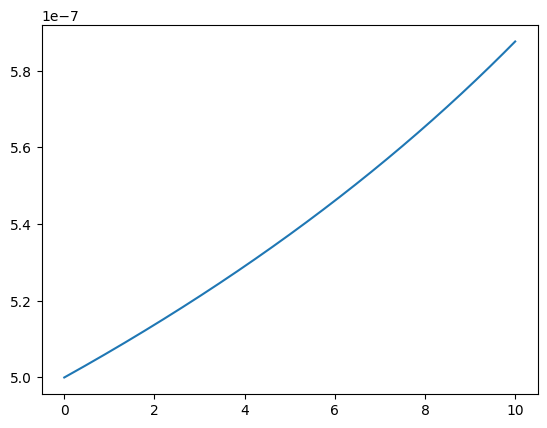

In [ ]:
plt.plot(t_span/yr,omg_arr)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
X_scaler = StandardScaler()
y_scaler = StandardScaler()

In [ ]:
class ANN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_hidden=4):
        super().__init__()
        layers = []
        in_size = input_size
        for _ in range(num_hidden):
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            in_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

In [ ]:
scaler_X, scaler_y = StandardScaler(), StandardScaler()

t_scaled = scaler_X.fit_transform(t_span.reshape(-1, 1))
omg_scaled = scaler_y.fit_transform(omg_arr.reshape(-1, 1))

# ------------------ Train-test split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    t_scaled, omg_scaled, test_size=0.2, random_state=42
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=512, shuffle=True)

In [ ]:
model = ANN(input_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(batch_X), batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_test_tensor.to(device)), y_test_tensor.to(device)).item()
    val_losses.append(val_loss)
    scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train: {train_losses[-1]:.6f}, "
              f"Val: {val_loss:.6f}")

Epoch 10/100, Train: 0.000016, Val: 0.000014
Epoch 20/100, Train: 0.000009, Val: 0.000009
Epoch 30/100, Train: 0.000008, Val: 0.000008
Epoch 40/100, Train: 0.000008, Val: 0.000008
Epoch 50/100, Train: 0.000008, Val: 0.000008
Epoch 60/100, Train: 0.000008, Val: 0.000008
Epoch 70/100, Train: 0.000008, Val: 0.000008
Epoch 80/100, Train: 0.000008, Val: 0.000008
Epoch 90/100, Train: 0.000008, Val: 0.000008
Epoch 100/100, Train: 0.000008, Val: 0.000008


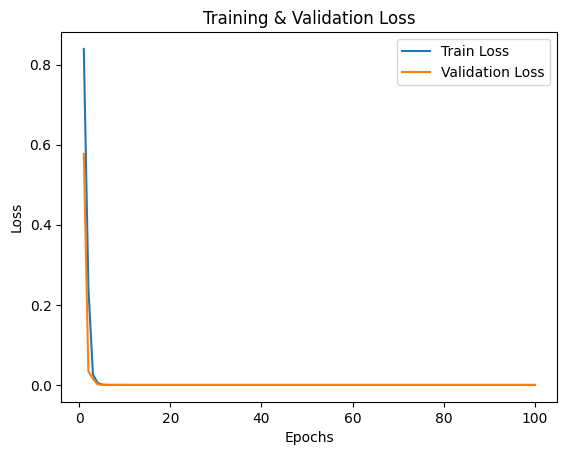

In [ ]:
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [ ]:
with torch.no_grad():
    omg_pred_scaled = model(torch.tensor(t_scaled, dtype=torch.float32).to(device)).cpu().numpy()
    omg_pred = scaler_y.inverse_transform(omg_pred_scaled)

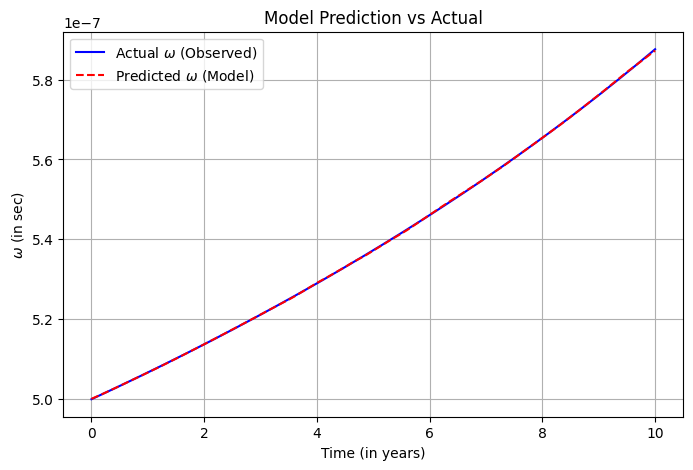

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(t_span/yr, omg_arr, label="Actual $\omega$ (Observed)", color="blue")
plt.plot(t_span/yr, omg_pred, label="Predicted $\omega$ (Model)", color="red", linestyle="--")
plt.xlabel("Time (in years)")
plt.ylabel(r"$\omega$ (in sec)")
plt.title("Model Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()